<a href="https://colab.research.google.com/github/Elizabeth0311/Algorithm_study/blob/main/n224a_model_selection_ipynb_1%EC%B0%A8%EC%A0%9C%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 4*

# 📝 Assignment
---

# 모델선택(Model Selection)

### 1) 캐글 대회를 이어서 진행합니다. RandomizedSearchCV 를 사용하여 하이퍼파라미터 튜닝을 진행합니다.

- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)를 사용하세요.
- 분류문제에서 맞는 [scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) metric을 사용하세요.
- [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) 사용을 권합니다.
- RandomizedSearchCV 를 사용해서 하이퍼파라미터 튜닝을 진행하고 최고 성능을 보이는 모델로 예측을 진행한 후 캐글에 제출합니다.
- **캐글 Leaderboard에서 개선된 본인 Score를 과제 제출폼에 제출하세요.**

In [ ]:
! pip install --upgrade scikit-learn

In [ ]:
! pip install category_encoders

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
target = 'vacc_h1n1_f'

train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')

In [ ]:
train.info()

In [3]:
# 훈련/검증세트로 나눔 
train, val = train_test_split(train, train_size=0.8, random_state=5)

In [4]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [5]:
train.shape, val.shape

((33723, 39), (8431, 39))

In [6]:
import numpy as np

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
    selected_cols = df.select_dtypes(include=['number', 'object'])
    labels = selected_cols.nunique() # 특성별 카디널리티 리스트
    selected_features = labels[labels <= 30].index.tolist() # 카디널리티가 30보다 작은 특성만 선택합니다.
    df = df[selected_features]
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

In [8]:
# 인코딩 

from category_encoders import OrdinalEncoder
enc = OrdinalEncoder(handle_missing="value" , mapping= [

{'col': 'opinion_h1n1_vacc_effective' , 
 'mapping': {'Somewhat Effective': 1, 
             'Not Very Effective': 6,
             'Very Effective': 1 ,
             'Not At All Effective': 5, 
             'Dont Know': 4, 
             'nan': 0,
             'Refused': 3}}, 
{'col': 'opinion_h1n1_risk' , 
 'mapping': {'Somewhat Low': 5, 
             'Somewhat High' : 2, 
             'Very Low' : 6 , 
             'nan' : 0, 
             'Very High' : 1,
             'Dont Know' : 4 , 
             'Refused' : 3}} , 
{'col' : 'opinion_h1n1_sick_from_vacc' , 
 'mapping' : {'Not At All Worried' : 3, 
              'Not Very Worried':4, 
              'Dont Know':5,
              'Somewhat Worried':2, 
              'Very Worried':1, 
              'nan':0, 
              'Refused':6}},
{'col' :'census_msa',
 'mapping' : {'MSA, Not Principle City' : 2,
              'MSA, Principle City': 1, 
              'Non-MSA' : 3}},
 {'col' :'agegrp', 
  'mapping' : {'18 - 34 Years' :3 , 
               '35 - 44 Years':4, 
               '65+ Years':5, 
               '55 - 64 Years':6,
               '45 - 54 Years' : 7, 
               '6 Months - 9 Years' : 1, 
               '10 - 17 Years' : 2}} 
])

X_train_encoded = enc.fit_transform(X_train)
X_val_encoded = enc.transform(X_val)
X_test_encoded = enc.transform(X_test)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=10)
)


k = 4

scores = cross_val_score(pipe, X_train_encoded, y_train, cv=k, 
                         scoring='roc_auc')

pipe.fit(X_train_encoded, y_train)
print('검증 정확도', pipe.score(X_val_encoded, y_val))
print('roc_auc =', scores)

검증 정확도 0.8268295575851026
roc_auc = [0.82782156 0.83334063 0.83595408 0.8329168 ]


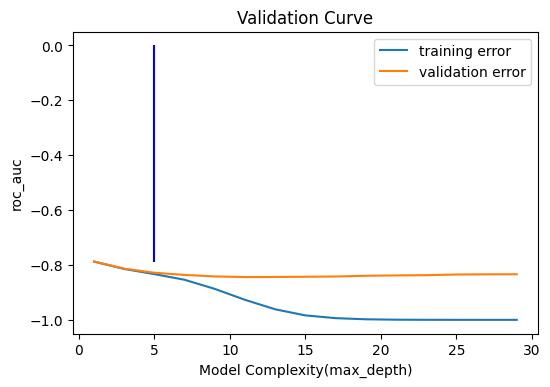

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

depth = range(1, 30, 2)
ts, vs = validation_curve(
    pipe, X_train_encoded, y_train
    , param_name='randomforestclassifier__max_depth'
    , param_range=depth, scoring='roc_auc'
    , cv=4
    , n_jobs=2
)

train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)

fig, ax = plt.subplots()
# 훈련세트 검증곡선
ax.plot(depth, train_scores_mean, label='training error')

# 검증세트 검증곡선
ax.plot(depth, validation_scores_mean, label='validation error')

# 이상적인 max_depth
ax.vlines(5,0, train_scores_mean.max(), color='blue')

# 그래프 셋팅
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(max_depth)', ylabel='roc_auc')
ax.legend()
fig.dpi = 100

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=10,)
)


dists = {"randomforestclassifier__n_estimators": randint(10, 100),
         "randomforestclassifier__max_depth": [5, 10, 15, 20, None],
          "randomforestclassifier__max_features": [2, 4, 6, 8, 10],
          "randomforestclassifier__min_samples_split": [1, 3, 5, 6, 9]}


clf = RandomizedSearchCV(
        pipe,
        param_distributions = dists,
        n_iter = 10,
        cv = 5,
        scoring = 'roc_auc',
        verbose=1,
        n_jobs= 2 
)

clf.fit(X_train_encoded, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.84232768 0.84397015        nan        nan        nan 0.83878423
 0.83914614 0.83070356 0.84179322 0.8301381 ]
  category=UserWarning


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=10))]),
                   n_jobs=2,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              15,
                                                                              20,
                                                                              None],
                                        'randomforestclassifier__max_features': [2,
                                                                              

In [12]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('roc_auc: ', clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 8, 'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__n_estimators': 83}
roc_auc:  0.8439701463604556


In [13]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T


,1,0,8,6,5,7,9,2,3,4
mean_fit_time,3.03798,4.39954,5.59626,2.96926,2.47832,0.750077,0.676004,0.173672,0.187899,0.18659
std_fit_time,0.0284544,0.0294002,0.123408,0.0217233,0.0152781,0.0177078,0.00487672,0.00261078,0.0082391,0.0104285
mean_score_time,0.119981,0.143489,0.174371,0.12276,0.16227,0.0603315,0.0410712,0,0,0
std_score_time,0.00974707,0.00515467,0.0175101,0.00538556,0.0085705,0.00302197,0.00223176,0,0,0
param_randomforestclassifier__max_depth,10,15,15,None,20,15,5,None,15,20
param_randomforestclassifier__max_features,8,10,10,8,4,4,10,4,6,2
param_randomforestclassifier__min_samples_split,6,6,3,9,5,3,3,1,1,1
param_randomforestclassifier__n_estimators,83,78,99,57,73,20,23,63,81,48
params,"{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran..."
split0_test_score,0.837867,0.837837,0.837284,0.83645,0.834798,0.823757,0.821367,NaN,NaN,NaN


In [14]:
pipe2 = clf.best_estimator_


In [15]:
#재학습 

train2, val2 = train_test_split(train, train_size=0.8, random_state= 5)

In [16]:
train2 = engineer(train2)
val2 = engineer(val2)
test = engineer(test)

In [17]:
features = train.drop(columns=[target]).columns

X_train2 = train2[features]
y_train2 = train2[target]
X_val2 = val2[features]
y_val2 = val2[target]
X_test = test[features]

In [18]:
X_train2_encoded = enc.fit_transform(X_train2)
X_val2_encoded = enc.transform(X_val2)
X_test_encoded = enc.transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [19]:
pipe2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators = 83, min_samples_split = 6, max_features = 8 ,max_depth = 10, random_state=5, n_jobs=2, oob_score=True)
)


pipe.fit(X_train2_encoded, y_train2)
print('검증 정확도', pipe.score(X_val2_encoded, y_val2))

검증 정확도 0.8229799851742031


In [20]:
y_pred = pipe.predict(X_test_encoded)

In [ ]:
submission = pd.DataFrame(y_pred,)
submission.reset_index(inplace=True)
submission.columns=['Id','vacc_h1n1_f']
submission.set_index('Id', inplace=True)
submission

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
submission.to_csv('/content/drive/MyDrive/Code states/submission.csv')

In [ ]:
0.53739

## 🔥 도전과제


### 2) [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 를 사용하여 하이퍼파라미터 튜닝을 진행합니다.
- 모델 성능을 높이기 위해 가능한 시도를 다 해보세요.
- 모델 성능에 가장 큰 영향을 준 하이퍼파라미터에 대해서 분석하고 설명해 보세요.



In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 